# 🎯 LLM-as-a-Judge

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 100%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
   LLM-as-a-Judge scorers use one or more LLMs to evaluate the reliability of the original LLM's response. They offer high customizability through prompt engineering and the choice of judge LLM(s). Below is a list of the available scorers:
  </p>

*   Categorical LLM-as-a-Judge ([Manakul et al., 2023](https://arxiv.org/abs/2303.08896); [Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175); [Luo et al., 2023](https://arxiv.org/pdf/2303.15621))
*   Continuous LLM-as-a-Judge ([Xiong et al., 2024](https://arxiv.org/pdf/2306.13063))
*   Panel of LLM Judges ([Verga et al., 2024](https://arxiv.org/abs/2404.18796))
    
</div>

## 📊 What You'll Do in This Demo


<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section1>Set up LLM and prompts.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Set up LLM instance and load example data prompts.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section2>Generate LLM Responses and Confidence Scores</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate and score LLM responses to the example questions using the <code>LLMPanel()</code> class.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section3>Evaluate Hallucination Detection Performance</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Compute precision, recall, and F1-score of hallucination detection.</p>
  </div>
</div>

## ⚖️ Advantages & Limitations

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Pros</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Universal Compatibility:</strong> Works with any LLM.</li>
      <li><strong>Highly Customizable:</strong> Use any LLM as a judge and tailor instruction prompts for specific use cases.</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(200, 0, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(200, 0, 0, 0.2)">
    <h3 style="color: #b22222; margin-top: 0">Cons</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Added cost:</strong> Requires additional LLM calls for the judge LLM(s).</li>
    </ul>
  </div>
</div>

In [1]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from uqlm import LLMPanel
from uqlm.utils import load_example_dataset, math_postprocessor, plot_model_accuracies, Tuner

<a id='section1'></a>
## 1. Set up LLM and Prompts

In this demo, we will illustrate this approach using a set of math questions from the [GSM8K benchmark](https://github.com/openai/grade-school-math). To implement with your use case, simply **replace the example prompts with your data**.  

In [2]:
# Load example dataset (gsm8k)
gsm8k = load_example_dataset("gsm8k", n=200)
gsm8k.head()

Loading dataset - gsm8k...
Processing dataset...
Dataset ready!


,question,answer
0,Natalia sold clips to 48 of her friends in Apr...,72
1,Weng earns $12 an hour for babysitting. Yester...,10
2,Betty is saving money for a new wallet which c...,5
3,"Julie is reading a 120-page book. Yesterday, s...",42
4,James writes a 3-page letter to 2 different fr...,624


In [3]:
# Define prompts
MATH_INSTRUCTION = "When you solve this math problem only return the answer with no additional text.\n"
prompts = [MATH_INSTRUCTION + prompt for prompt in gsm8k.question]

In this example, we use `ChatVertexAI` and `AzureChatOpenAI` to instantiate our LLMs, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used. Be sure to **replace with your LLM of choice.**

In [4]:
# import sys
# !{sys.executable} -m pip install langchain-openai

# # User to populate .env file with API credentials
from dotenv import load_dotenv, find_dotenv
from langchain_openai import AzureChatOpenAI

load_dotenv(find_dotenv())
original_llm = AzureChatOpenAI(
    deployment_name="gpt-4o",
    openai_api_type="azure",
    openai_api_version="2024-02-15-preview",
    temperature=1,  # User to set temperature
)

In [5]:
# import sys
# !{sys.executable} -m pip install langchain-google-vertexai
from langchain_google_vertexai import ChatVertexAI

gemini_pro = ChatVertexAI(model_name="gemini-1.5-pro")
gemini_flash = ChatVertexAI(model_name="gemini-1.5-flash")

<a id='section2'></a>
## 2. Generate responses and confidence scores

### `LLMPanel()` - Class for aggregating multiple instances of LLMJudge using average, min, max, or majority voting

![Sample Image](https://raw.githubusercontent.com/cvs-health/uqlm/develop/assets/images/judges_graphic.png)

#### 📋 Class Attributes

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 20%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Parameter</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Type & Default</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 55%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description</th>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">judges</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">list of LLMJudge or BaseChatModel<br><code></code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Judges to use. If BaseChatModel, LLMJudge is instantiated using default parameters.</td>
  </tr>    
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel`. User is responsible for specifying temperature and other relevant parameters to the constructor of the provided `llm` object.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">system_prompt</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or None<br><code>default="You are a helpful assistant."</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Optional argument for user to provide custom system prompt for the LLM.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_calls_per_min</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how many API calls to make per minute to avoid rate limit errors. By default, no limit is specified.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">scoring_templates</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which off-the-shelf template to use for each judge. Four off-the-shelf templates offered: incorrect/uncertain/correct (0/0.5/1), incorrect/correct (0/1), continuous score (0 to 1), and likert scale score (1-5 scale, normalized to 0/0.25/0.5/0.75/1). These templates are respectively specified as 'true_false_uncertain', 'true_false', 'continuous', and 'likert'. If specified, must be of equal length to `judges` list. Defaults to 'true_false_uncertain' template used by Chen and Mueller (2023) for each judge.</td>
  </tr>
</table>

#### 🔍 Parameter Groups

<div style="display: flex; gap: 20px; margin-bottom: 20px">
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 100, 200, 0.1); border-radius: 5px; border: 1px solid rgba(0, 100, 200, 0.2);">
    <p style="font-weight: bold">🧠 LLM-Specific</p>
    <ul>
      <li><code>llm</code></li>
      <li><code>system_prompt</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 200, 0, 0.1); border-radius: 5px; border: 1px solid rgba(0, 200, 0, 0.2);">
    <p style="font-weight: bold">📊 Confidence Scores</p>
    <ul>
      <li><code>judges</code></li>
      <li><code>scoring_templates</code></li>        
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 0, 200, 0.1); border-radius: 5px; border: 1px solid rgba(200, 0, 200, 0.2);">
    <p style="font-weight: bold">⚡ Performance</p>
    <ul>
      <li><code>max_calls_per_min</code></li>
    </ul>
  </div>
</div>

#### 💻 Usage Examples

```python
# Basic usage with single self-judge parameters
panel = LLMPanel(llm=llm, judges=[llm])

# Using two judges with default parameters
panel = LLMPanel(llm=llm, judges=[llm, llm2])

# Using two judges, one with continuous template
panel = LLMPanel(
    llm=llm, judges=[llm, llm2], scoring_templates=['true_false_uncertain', 'continuous']
)
```

In [6]:
panel = LLMPanel(llm=original_llm, judges=[gemini_pro, gemini_flash, original_llm], scoring_templates=["continuous"] * 3)

### 🔄 Class Methods

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Method</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 75%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description & Parameters</th>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">LLMPanel.generate_and_score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Generate responses to provided prompts and use panel to of judges to score responses for correctness.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>prompts</code> - (<strong>list of str</strong>) A list of input prompts for the model.</li>
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while generating and scoring responses.</li>        
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (prompts, responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Complete end-to-end uncertainty quantification when starting with prompts.
      </div>
    </td>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">LLMPanel.score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Use panel to of judges to score provided responses for correctness. Use if responses are already generated. Otherwise, use `generate_and_score`.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>prompts</code> - (<strong>list of str</strong>) A list of input prompts for the model.</li>
        <li><code>responses</code> - (<strong>list of str</strong>) A list of LLM responses for the prompts.</li>
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while scoring responses.</li>  
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (responses and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Computing uncertainty scores when responses are already generated elsewhere.
      </div>
    </td>
  </tr>
</table>

In [7]:
result = await panel.generate_and_score(prompts=prompts)

# option 2: provide pre-generated responses with score method
# result = await panel.score(prompts=prompts, responses=responses)

Output()

In [8]:
result_df = result.to_df()
result_df.head()

,prompt,response,judge_1,judge_2,judge_3,avg,max,min,median
0,When you solve this math problem only return t...,72,1.00,0.72,1.00,0.906667,1.00,0.72,1.00
1,When you solve this math problem only return t...,$10,1.00,0.10,0.75,0.616667,1.00,0.10,0.75
2,When you solve this math problem only return t...,$20,1.00,0.20,0.90,0.700000,1.00,0.20,0.90
3,When you solve this math problem only return t...,48,1.00,0.80,0.60,0.800000,1.00,0.60,0.80
4,When you solve this math problem only return t...,624,0.99,0.99,0.98,0.986667,0.99,0.98,0.99


<a id='section3'></a>
## 3. Evaluate Hallucination Detection Performance

To evaluate hallucination detection performance, we 'grade' the responses against an answer key. Note the `math_postprocessor` is specific to our use case (math questions). **If you are using your own prompts/questions, update the grading method accordingly**.

In [9]:
# Populate correct answers
result_df["answer"] = gsm8k.answer

# Grade responses against correct answers
result_df["response_correct"] = [math_postprocessor(r) == a for r, a in zip(result_df["response"], gsm8k["answer"])]
result_df.head(5)

,prompt,response,judge_1,judge_2,judge_3,avg,max,min,median,answer,response_correct
0,When you solve this math problem only return t...,72,1.00,0.72,1.00,0.906667,1.00,0.72,1.00,72,True
1,When you solve this math problem only return t...,$10,1.00,0.10,0.75,0.616667,1.00,0.10,0.75,10,True
2,When you solve this math problem only return t...,$20,1.00,0.20,0.90,0.700000,1.00,0.20,0.90,5,False
3,When you solve this math problem only return t...,48,1.00,0.80,0.60,0.800000,1.00,0.60,0.80,42,False
4,When you solve this math problem only return t...,624,0.99,0.99,0.98,0.986667,0.99,0.98,0.99,624,True


In [10]:
print(f"""Baseline LLM accuracy: {np.mean(result_df["response_correct"])}""")

Baseline LLM accuracy: 0.5


#### 3.1 Filtered LLM Accuracy Evaluation

Here, we explore ‘filtered accuracy’ as a metric for evaluating the performance of our confidence scores. Filtered accuracy measures the change in LLM performance when responses with confidence scores below a specified threshold are excluded. By adjusting the confidence score threshold, we can observe how the accuracy of the LLM improves as less certain responses are filtered out.

We will plot the filtered accuracy across various confidence score thresholds to visualize the relationship between confidence and LLM accuracy. This analysis helps in understanding the trade-off between response coverage (measured by sample size below) and LLM accuracy, providing insights into the reliability of the LLM’s outputs. We conduct this analysis separately for each of our scorers. 

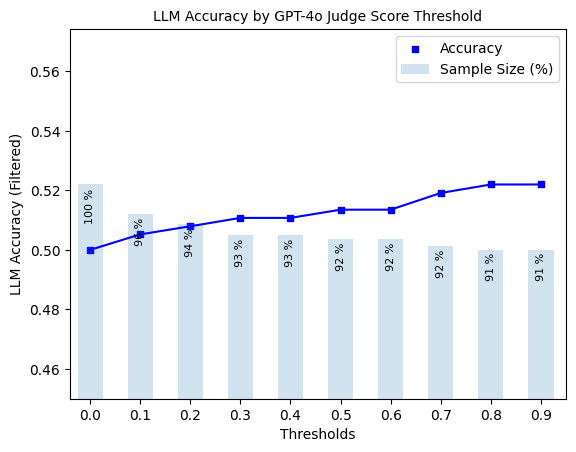

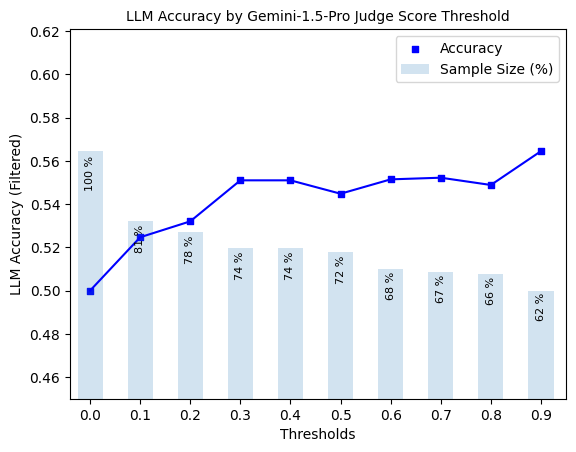

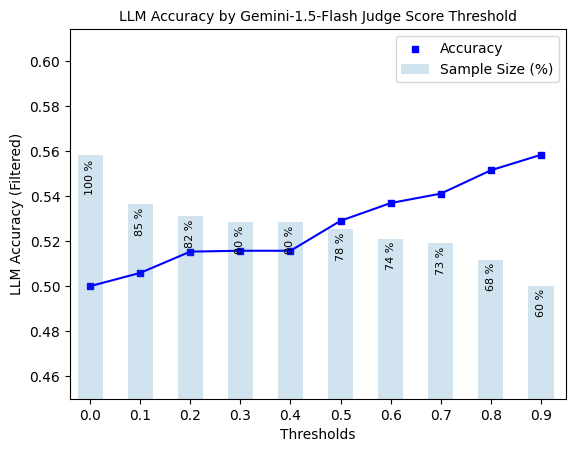

In [11]:
scorer_to_name = {"judge_1": "GPT-4o", "judge_2": "Gemini-1.5-Pro", "judge_3": "Gemini-1.5-Flash"}
for scorer in ["judge_1", "judge_2", "judge_3"]:
    plot_model_accuracies(scores=result_df[scorer], correct_indicators=result_df.response_correct, title=f"LLM Accuracy by {scorer_to_name[scorer]} Judge Score Threshold", display_percentage=True)

#### 3.2 Precision, Recall, F1-Score of Hallucination Detection

Lastly, we compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using this threshold, we compute precision, recall, and F1-score for black box scorer predictions of whether responses are correct.

In [12]:
# instantiate UQLM tuner object for threshold selection
split = len(result_df) // 2
t = Tuner()

correct_indicators = (result_df.response_correct) * 1  # Whether responses is actually correct
metric_values = {"Precision": [], "Recall": [], "F1-score": []}
optimal_thresholds = []
for confidence_score in ["judge_1", "judge_2", "judge_3"]:
    # tune threshold on first half
    y_scores = result_df[confidence_score]
    y_scores_tune = y_scores[0:split]
    y_true_tune = correct_indicators[0:split]
    best_threshold = t.tune_threshold(y_scores=y_scores_tune, correct_indicators=y_true_tune, thresh_objective="fbeta_score")

    y_pred = [(s > best_threshold) * 1 for s in y_scores]  # predicts whether response is correct based on confidence score
    optimal_thresholds.append(best_threshold)

    # evaluate on last half
    y_true_eval = correct_indicators[split:]
    y_pred_eval = y_pred[split:]
    metric_values["Precision"].append(precision_score(y_true=y_true_eval, y_pred=y_pred_eval))
    metric_values["Recall"].append(recall_score(y_true=y_true_eval, y_pred=y_pred_eval))
    metric_values["F1-score"].append(f1_score(y_true=y_true_eval, y_pred=y_pred_eval))

# print results
header = f"{'Metrics':<25}" + "".join([f"{scorer_name:<25}" for scorer_name in ["judge_1", "judge_2", "judge_3"]])
print("=" * len(header) + "\n" + header + "\n" + "-" * len(header))
for metric in metric_values.keys():
    print(f"{metric:<25}" + "".join([f"{round(x_, 3):<25}" for x_ in metric_values[metric]]))
print("-" * len(header))
print(f"{'F-1 optimal threshold':<25}" + "".join([f"{round(x_, 3):<25}" for x_ in optimal_thresholds]))
print("=" * len(header))

Metrics                  judge_1                  judge_2                  judge_3                  
----------------------------------------------------------------------------------------------------
Precision                0.512                    0.519                    0.477                    
Recall                   0.854                    0.875                    0.875                    
F1-score                 0.641                    0.651                    0.618                    
----------------------------------------------------------------------------------------------------
F-1 optimal threshold    0.95                     0.1                      0.04                     


<a id='section5'></a>
## 5. Scorer Definitions
Under the LLM-as-a-Judge approach, either the same LLM that was used for generating the original responses or a different LLM is asked to form a judgment about a pre-generated response. Below, we define two LLM-as-a-Judge scorer templates. 
### Categorical Judge Template (`true_false_uncertain`)
We follow the approach proposed by [Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175) in which an LLM is instructed to score a question-answer concatenation as either  *incorrect*, *uncertain*, or *correct* using a carefully constructed prompt. These categories are respectively mapped to numerical scores of 0, 0.5, and 1. We denote the LLM-as-a-judge scorers as $J: \mathcal{Y} \xrightarrow[]{} \{0, 0.5, 1\}$. Formally, we can write this scorer function as follows:

\begin{equation}
J(y_i) = \begin{cases}
    0 & \text{LLM states response is incorrect} \\
    0.5 & \text{LLM states that it is uncertain} \\
    1 & \text{LLM states response is correct}.
\end{cases}
\end{equation}

### Continuous Judge Template (`continuous`)
For the continuous template, the LLM is asked to directly score a question-answer concatenation's correctness on a scale of 0 to 1. 

### Likert Scale Judge Template (`continuous`)
For the Likert Scale template, the LLM is asked to score a response's correctness from 1 to 5. These scores are normalized on a 0 to 1 scale as (0.25,...,1). 

© 2025 CVS Health and/or one of its affiliates. All rights reserved.